In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("traindata.csv")

In [4]:
train.info()
#Data is coming in int64 and float64 format. TODO -> to change it.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982295 entries, 0 to 982294
Data columns (total 12 columns):
Unnamed: 0        982295 non-null int64
WeekNumber        982295 non-null int64
DepotID           982295 non-null int64
SalesChannelID    982295 non-null int64
RouteID           982295 non-null int64
ClientID          982295 non-null int64
ProductID         528498 non-null float64
SalesUnits        982295 non-null int64
Sales             982295 non-null float64
ReturnUnits       982295 non-null int64
Returns           982295 non-null float64
Demand            982295 non-null int64
dtypes: float64(3), int64(9)
memory usage: 89.9 MB


In [3]:
clientdata = pd.read_csv("./cliente_tabla.csv/cliente_tabla.csv")
productdata = pd.read_csv("./producto_tabla.csv/producto_tabla.csv")
townstate = pd.read_csv("./town_state.csv/town_state.csv")

In [6]:
test = pd.read_csv("./test.csv/test.csv")

In [7]:
cleanTest = test[test['Canal_ID'] == 11]
del test

In [10]:
#It is noticed that many clients have same/similar names but different client IDs. We will try to
#distinctly identify all individual clients. Using new column 'DistinctClientID'

In [4]:
ClientCounts = clientdata['NombreCliente'].value_counts()

In [5]:
cleanClientData = pd.DataFrame(data=ClientCounts.index.values, columns=['Name'])

In [6]:
cleanClientData.reset_index(inplace=True)

In [23]:
#For products, it is a good idea to extract the main name of each of the product using regular expression. Since we see that the main name 
#has a number after it. we can just separate on the first appearing number.

In [7]:
import re
#Split the string at the first digit character:
productdata['shortname'] = productdata['NombreProducto'].apply(lambda x:  re.split("\s\d", x, 1)[0])


In [30]:
#We find using the shortname that 2500 products are actually 1000 products with different size variants

In [58]:
train.tail()

,Unnamed: 0,WeekNumber,DepotID,SalesChannelID,RouteID,ClientID,ProductID,SalesUnits,Sales,ReturnUnits,Returns,Demand
982290,982290,9,24669,11,3901,4620106,NaN,16,494.56,0,0.0,16
982291,982291,9,24669,11,3901,4714568,NaN,20,262.80,0,0.0,20
982292,982292,9,24669,11,3901,4728956,NaN,6,185.46,0,0.0,6
982293,982293,9,24669,11,3901,7684929,NaN,4,123.64,0,0.0,4
982294,982294,9,24669,11,3901,7833780,NaN,10,309.10,0,0.0,10


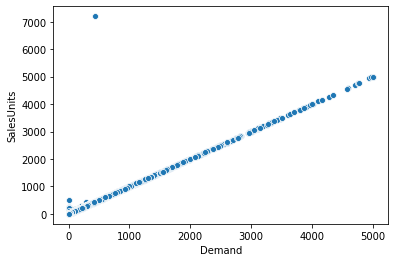

In [13]:
#Plotting between Sales and Demand for products
sns.scatterplot(x='Demand', y='SalesUnits',data=train)

#the plot tells us that demand and sales are exactly same for prod 1146, and there are no returns

In [14]:
(train['SalesUnits'] - train['ReturnUnits'] - train['Demand']).value_counts()
#There are instances where sales-return is not equal to the demand. This is probably because the returns are not always made the next
#week but on subsequent weeks. In that case, sales - returns might be negative but demand should be a positive number, so adjusted 
#demand will be zero.

 0       974496
-1         1536
-2          849
-3          532
-4          451
          ...  
-194          1
-193          1
-192          1
-704          1
-1673         1
Length: 280, dtype: int64

In [64]:
train[(train['ReturnUnits'] > 0) & (train['ProductID'] == 1700.0) & (train['ClientID'] == 4528790)]
#we see here that demand will be 0 when returns are more than sales.

,Unnamed: 0,WeekNumber,DepotID,SalesChannelID,RouteID,ClientID,ProductID,SalesUnits,Sales,ReturnUnits,Returns,Demand
44000,44000,3,1680,11,5705,4528790,1700.0,3,42.0,49,686.0,0
183032,183032,4,1680,11,5705,4528790,1700.0,0,0.0,4,56.0,0
451967,451967,6,1680,11,5705,4528790,1700.0,4,56.0,1,14.0,3
726615,726615,8,1680,11,5705,4528790,1700.0,10,140.0,1,14.0,9


In [65]:
#We also see that products might not be sold in all weeks. Here no sales are made in week 5,7 and 9. 

In [66]:
#Many of the productids in the training data are NAN. We would require to remove those from our preprocessing. 
#We cannot estimate demand for product which is unknown. 

In [8]:
train.dropna(subset=['ProductID','ClientID'], inplace=True)

In [42]:
len(train)

528498

In [17]:
cleanTest.dropna(subset=['Producto_ID','Cliente_ID'], inplace=True)

3903    22269
3901    22111
3904    20319
3908    20002
3905    19795
        ...  
3559       72
3985       66
3560       46
3974       36
3973        5
Name: RouteID, Length: 153, dtype: int64

([array([     0.,      0.,   7099.,      0.,      0.,  63448.,      0.,
          82708.,      0., 103356.,  48950.,  61039.,  57588.,  32273.,
          36643.,  18638.,  10757.,   4381.,   1251.,    367.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.])],
 array([-0.326978  , -0.16729611, -0.00761421,  0.15206768,  0.31174958,
         0.47143147,  0.63111337,  0.79079526,  0.95047716,  1.11015905,
         1.26984095,  1.42952284,  1.58920474,  1.74888663,  1.90856853,
         2.06825042,  2.22793232,  2.38761421,  2.54729611,  2.706978  ,
         2.8666599 ]),
 <a list of 2 Lists of Patches objects>)

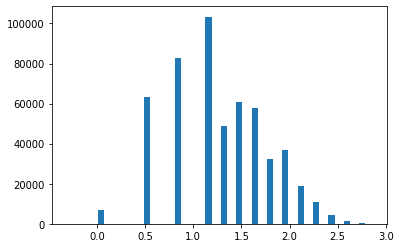

In [9]:
from scipy.stats import norm,boxcox
plt.hist(boxcox(train['Demand'] + 1), bins = 20)

In [119]:
#Hence the data is succesfully transformed to normalised data. We need to reverse the transformation when we get the testdata
#results
boxcoxFactor = -0.3269780047195248

In [10]:
train['normDemand'] = boxcox(train['Demand'] + 1)[0]

In [58]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Imputer
from sklearn.model_selection import cross_val_score, cross_val_predict

In [35]:
import gc

In [44]:
train.drop(["Unnamed: 0","SalesChannelID","SalesUnits","Sales","ReturnUnits","Returns","Demand"], axis=1, inplace=True)

In [48]:
X_train = train[train['WeekNumber'] != 9].copy()
y_train = X_train['normDemand']
X_test = train[train['WeekNumber'] == 9].copy()
y_test = X_test['normDemand']
X_train.drop(["normDemand"],axis=1, inplace=True)
X_test.drop(["normDemand"],axis=1, inplace=True)

In [49]:
hyper_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'l1'],
    'n_estimators' : 100
}
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric=['l1','l2'],
        categorical_feature = ['WeekNumber','DepotID','RouteID','ClientID','ProductID'],
        verbose = True)


C:\Users\sablo\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ClientID', 'DepotID', 'ProductID', 'RouteID', 'WeekNumber']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.224673	training's l1: 0.383894	valid_1's l2: 0.231383	valid_1's l1: 0.390718
[2]	training's l2: 0.216241	training's l1: 0.376622	valid_1's l2: 0.223264	valid_1's l1: 0.383691
[3]	training's l2: 0.209048	training's l1: 0.370195	valid_1's l2: 0.216465	valid_1's l1: 0.377522
[4]	training's l2: 0.202831	training's l1: 0.364824	valid_1's l2: 0.210634	valid_1's l1: 0.372437
[5]	training's l2: 0.197133	training's l1: 0.359624	valid_1's l2: 0.205259	valid_1's l1: 0.367465
[6]	training's l2: 0.192208	training's l1: 0.355082	valid_1's l2: 0.200648	valid_1's l1: 0.363224
[7]	training's l2: 0.188168	training's l1: 0.35126	valid_1's l2: 0.197008	valid_1's l1: 0.359715
[8]	training's l2: 0.184024	training's l1: 0.347192	valid_1's l2: 0.193225	valid_1's l1: 0.355951
[9]	training's l2: 0.180591	training's l1: 0.343814	valid_1's l2: 0.190139	valid_1's l1: 0.352886
[10]	training's l2: 0.177476	training's l1: 0.340687	valid_1's l2: 0.187138	valid_1's l1: 0.349844
[11]	training's l2: 

[85]	training's l2: 0.120514	training's l1: 0.267954	valid_1's l2: 0.141037	valid_1's l1: 0.291296
[86]	training's l2: 0.120334	training's l1: 0.267663	valid_1's l2: 0.140888	valid_1's l1: 0.291059
[87]	training's l2: 0.120152	training's l1: 0.267365	valid_1's l2: 0.140763	valid_1's l1: 0.29084
[88]	training's l2: 0.119987	training's l1: 0.267093	valid_1's l2: 0.140641	valid_1's l1: 0.29062
[89]	training's l2: 0.119816	training's l1: 0.266817	valid_1's l2: 0.1405	valid_1's l1: 0.29042
[90]	training's l2: 0.119643	training's l1: 0.266531	valid_1's l2: 0.140367	valid_1's l1: 0.290216
[91]	training's l2: 0.119358	training's l1: 0.266146	valid_1's l2: 0.140156	valid_1's l1: 0.289911
[92]	training's l2: 0.119091	training's l1: 0.265765	valid_1's l2: 0.139957	valid_1's l1: 0.289643
[93]	training's l2: 0.118943	training's l1: 0.265514	valid_1's l2: 0.139839	valid_1's l1: 0.289453
[94]	training's l2: 0.118785	training's l1: 0.265249	valid_1's l2: 0.139715	valid_1's l1: 0.289256
[95]	training's

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric=['l2', 'l1'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [50]:
gbm.feature_importances_

array([   0,   64,   62, 2656,  218])

In [51]:
gbm.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('l2', 0.1176226448640563),
                          ('l1', 0.2634903452999561)]),
             'valid_1': OrderedDict([('l2', 0.13887230425420422),
                          ('l1', 0.28797662221036585)])})

In [52]:
pred = gbm.predict(X_test)

In [55]:
gbm.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('l2', 0.1176226448640563),
                          ('l1', 0.2634903452999561)]),
             'valid_1': OrderedDict([('l2', 0.13887230425420422),
                          ('l1', 0.28797662221036585)])})

In [59]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(pred, y_test) ** 0.5, 5))

The rmse of prediction is: 0.37266


In [60]:
pred

array([1.09677111, 1.17034535, 1.17649727, ..., 1.36064771, 1.45623557,
       1.36036661])

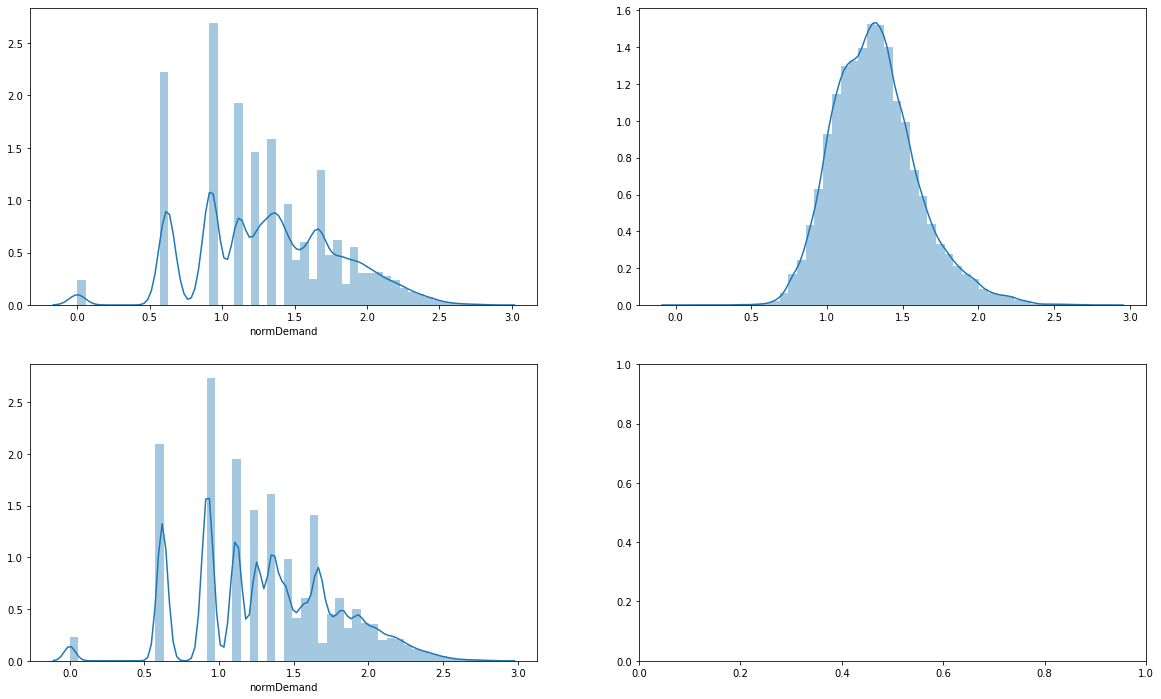

In [70]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize = (20,12))
sns.distplot(y_test, ax=axes[0][0])
sns.distplot(pred,ax=axes[0][1])
sns.distplot(train['normDemand'], ax=axes[1][0])

In [71]:
benchmark = 0.37266

""


In [78]:
#Adding Week Number as a numerical feature
hyper_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'l1'],
    'n_estimators' : 100
}
gbm2 = lgb.LGBMRegressor(**hyper_params)
gbm2.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric=['l1','l2'],
        categorical_feature = ['DepotID','RouteID','ClientID','ProductID'],
        verbose = True)

C:\Users\sablo\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ClientID', 'DepotID', 'ProductID', 'RouteID']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.224673	training's l1: 0.383894	valid_1's l2: 0.231383	valid_1's l1: 0.390718
[2]	training's l2: 0.216241	training's l1: 0.376622	valid_1's l2: 0.223264	valid_1's l1: 0.383691
[3]	training's l2: 0.209048	training's l1: 0.370195	valid_1's l2: 0.216465	valid_1's l1: 0.377522
[4]	training's l2: 0.202831	training's l1: 0.364824	valid_1's l2: 0.210634	valid_1's l1: 0.372437
[5]	training's l2: 0.197133	training's l1: 0.359624	valid_1's l2: 0.205259	valid_1's l1: 0.367465
[6]	training's l2: 0.192208	training's l1: 0.355082	valid_1's l2: 0.200648	valid_1's l1: 0.363224
[7]	training's l2: 0.188168	training's l1: 0.35126	valid_1's l2: 0.197008	valid_1's l1: 0.359715
[8]	training's l2: 0.184024	training's l1: 0.347192	valid_1's l2: 0.193225	valid_1's l1: 0.355951
[9]	training's l2: 0.180591	training's l1: 0.343814	valid_1's l2: 0.190139	valid_1's l1: 0.352886
[10]	training's l2: 0.177476	training's l1: 0.340687	valid_1's l2: 0.187138	valid_1's l1: 0.349844
[11]	training's l2: 

[85]	training's l2: 0.120514	training's l1: 0.267954	valid_1's l2: 0.141037	valid_1's l1: 0.291296
[86]	training's l2: 0.120334	training's l1: 0.267663	valid_1's l2: 0.140888	valid_1's l1: 0.291059
[87]	training's l2: 0.120152	training's l1: 0.267365	valid_1's l2: 0.140763	valid_1's l1: 0.29084
[88]	training's l2: 0.119987	training's l1: 0.267093	valid_1's l2: 0.140641	valid_1's l1: 0.29062
[89]	training's l2: 0.119816	training's l1: 0.266817	valid_1's l2: 0.1405	valid_1's l1: 0.29042
[90]	training's l2: 0.119643	training's l1: 0.266531	valid_1's l2: 0.140367	valid_1's l1: 0.290216
[91]	training's l2: 0.119358	training's l1: 0.266146	valid_1's l2: 0.140156	valid_1's l1: 0.289911
[92]	training's l2: 0.119091	training's l1: 0.265765	valid_1's l2: 0.139957	valid_1's l1: 0.289643
[93]	training's l2: 0.118943	training's l1: 0.265514	valid_1's l2: 0.139839	valid_1's l1: 0.289453
[94]	training's l2: 0.118785	training's l1: 0.265249	valid_1's l2: 0.139715	valid_1's l1: 0.289256
[95]	training's

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric=['l2', 'l1'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [80]:
pred2 = gbm2.predict(X_test)
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(pred2, y_test) ** 0.5, 5))

The rmse of prediction is: 0.37266


In [81]:
#No decrease in error using week as Numerical, but it makes more sense rather than being categorical.

In [82]:
#Using town ID as a categorical feature
townstate.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [11]:
townValues = townstate['Town'].value_counts()
townID = pd.DataFrame(data=townValues.index.values, columns=['Name'])

In [19]:
townstate = townstate.merge(townID,left_on=['Town'],right_on=['Name'])

In [20]:
train['TownID'] = train.reset_index().merge(townstate,left_on=['DepotID'],
                                            right_on=['Agencia_ID']).set_index('index_x')['index_y']

In [21]:
productValues = productdata['shortname'].value_counts()
productID = pd.DataFrame(data=productValues.index.values, columns=['Name'])

In [23]:
productdata = productdata.merge(productID,left_on=['shortname'],right_on=['Name'])

In [25]:
train['CatProductID'] = train.reset_index().merge(productdata,left_on=['ProductID'],
                                                  right_on=['Producto_ID']).set_index('index_x')['index_y']

In [29]:
#ClientID should be unique
clientdata = clientdata.merge(cleanClientData,left_on=['NombreCliente'],right_on=['Name'])
uniclientData = clientdata.groupby(['Cliente_ID']).mean().reset_index()
train['CleanClientID'] = train.reset_index().merge(uniclientData,left_on=['ClientID'],
                                                  right_on=['Cliente_ID']).set_index('index_x')['index_y']

In [30]:
train.head()

,Unnamed: 0,WeekNumber,DepotID,SalesChannelID,RouteID,ClientID,ProductID,SalesUnits,Sales,ReturnUnits,Returns,Demand,normDemand,TownID,CatProductID,CleanClientID
0,0,3,1110,11,3501,24700,2233.0,15,299.10,0,0.0,15,1.823043,51,0,99824.0
2,2,3,1110,11,3501,49265,1146.0,2,42.78,0,0.0,2,0.922939,51,5,181695.0
4,4,3,1110,11,3501,49652,1146.0,4,85.56,0,0.0,4,1.251412,51,5,254327.0
5,5,3,1110,11,3501,49652,2233.0,10,199.40,0,0.0,10,1.662041,51,0,254327.0
7,7,3,1110,11,3501,1208432,641.0,2,81.90,0,0.0,2,0.922939,51,294,212637.0


In [34]:
#Feature Engineering
#SalesUnits sum for each ProductID
train['AggProductSales'] = train.reset_index().merge(train.groupby('ProductID').sum()['SalesUnits'], on='ProductID').set_index('index')['SalesUnits_y']

In [37]:
#Sales Units mean for each ProductID
train['AvgProductSales'] = train.reset_index().merge(train.groupby('ProductID').mean()['SalesUnits'], on='ProductID').set_index('index')['SalesUnits_y']

In [51]:
#demand for each client product combination
train['AvgClientProdDemand'] = train.reset_index().merge(train.groupby(['ClientID','ProductID']).mean()['Demand'], on=['ClientID','ProductID']).set_index('index')['Demand_y']

In [41]:
#demand for each client
train['AvgClientDemand'] = train.reset_index().merge(train.groupby(['ClientID']).mean()['Demand'], on=['ClientID']).set_index('index')['Demand_y']

In [47]:
#Agg Demand for product in each city.
train['AggTownProductDemand'] = train.reset_index().merge(train.groupby(['TownID','ProductID']).sum()['Demand'], on=['TownID','ProductID']).set_index('index')['Demand_y']

In [48]:
#Avg Demand for product in each city.
train['AvgTownProductDemand'] = train.reset_index().merge(train.groupby(['TownID','ProductID']).mean()['Demand'], on=['TownID','ProductID']).set_index('index')['Demand_y']

In [52]:
#Standard Deviation of product demand at each client.
train['StdClientProdDemand'] = train.reset_index().merge(train.groupby(['ClientID','ProductID']).std()['Demand'], on=['ClientID','ProductID']).set_index('index')['Demand_y']

In [53]:
#Weekly average demand of each product
train['AvgWeeklyProdDemand'] = train.reset_index().merge(train.groupby(['WeekNumber','ProductID']).mean()['Demand'], on=['WeekNumber','ProductID']).set_index('index')['Demand_y']

In [54]:
#Weekly agg demand of each product
train['AggWeeklyProdDemand'] = train.reset_index().merge(train.groupby(['WeekNumber','ProductID']).sum()['Demand'], on=['WeekNumber','ProductID']).set_index('index')['Demand_y']

In [71]:
#Demand for Prior week for Weeks -> 4,9
for week in range(4,9):
    indices = train[train['WeekNumber'] == week].index.values
    train.loc[indices,'PriorWeekDem'] = train.reset_index().merge(train[train['WeekNumber'] == (week-1)].copy().groupby(['ClientID','ProductID']).mean()['Demand'], on=['ClientID','ProductID']).set_index('index')['Demand_y']


In [72]:
train.head()

,WeekNumber,DepotID,SalesChannelID,RouteID,ClientID,ProductID,SalesUnits,Sales,ReturnUnits,Returns,...,AggProductSales,AvgProductSales,AvgClientProdDemand,AvgClientDemand,AggTownProductDemand,AvgTownProductDemand,StdClientProdDemand,AvgWeeklyProdDemand,AggWeeklyProdDemand,PriorWeekDem
0,3,1110,11,3501,24700,2233.0,15,299.10,0,0.0,...,332676,9.959167,17.000000,17.000000,3523,7.339583,2.645751,9.532191,43381,NaN
2,3,1110,11,3501,49265,1146.0,2,42.78,0,0.0,...,218106,7.913574,2.000000,2.538462,2265,5.565111,0.000000,8.112520,30714,NaN
4,3,1110,11,3501,49652,1146.0,4,85.56,0,0.0,...,218106,7.913574,2.857143,6.214286,2265,5.565111,1.214986,8.112520,30714,NaN
5,3,1110,11,3501,49652,2233.0,10,199.40,0,0.0,...,332676,9.959167,9.571429,6.214286,3523,7.339583,3.207135,9.532191,43381,NaN
7,3,1110,11,3501,1208432,641.0,2,81.90,0,0.0,...,6216,5.447853,3.142857,2.875000,1691,7.384279,0.899735,5.789916,689,NaN


In [73]:
train.to_csv("ModTrain.csv")

In [74]:
del train

In [75]:
import gc
gc.collect()

69654